# Inspecting the results of `bmfm-multi-omics` for visualiing the embeddings using t-SNE and PCA...

Assigning cell type annotations is an import and time consuming part of single-cell analysis. BMFM-RNA simplifies this process by not only performing the cell-type annotation but also the preprocessing and visualisation through the embeddings created by the model.

In this tutorial we look at inspecting the results of the zero-shot prediction created in tutorial 1. We do this by loading the results of the data and then using the helper functions packaged in the `evaluation` module to help extract and interpret the results of the model.

In [2]:

import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc

from bmfm_targets.evaluation.embeddings import generate_clusters
from bmfm_targets.evaluation.plots import (
    plot_embeddings,
)
from bmfm_targets.evaluation.predictions import get_general_cell_type

/proj/bmfm/users/sanjoy/miniforge3/envs/bmfm-targets/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


## Load Original input data

To demostrate the BMFM-RNAs abilites, we use the PBMC data created by 10X Genomics (dataset can be downloaded [here](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). This dataset is created of 3k PBMCs from a Healthy Donor. The raw data will be used as the input, but we will also extract the cell type annotation from the legacy scanpy workflow as a comparison between the BMFM and classical scRNA-seq analysis. 

For more information about how the data was preprocessed please visit scanpy's tutorial [here](https://scanpy.readthedocs.io/en/1.11.x/tutorials/basics/clustering-2017.html).

In [34]:
input_directory="/proj/bmfm/datasets/omics/genome/finetune_datasets/lenti_mpra_regression/K562_original/"
reference_labels = pd.read_csv(input_directory + "test.csv")
reference_labels.head()

chunk  mean_value
0  AGGACCGGATCAACTCATCTACATAGAAGTCGCCCTGTCCGTGATG...       0.628
1  AGGACCGGATCAACTTTGCTCCTTAACACAGGCTAAGGACCAGCTT...       1.263
2  AGGACCGGATCAACTTCCCTGGTGGTCTAGTGGTTAGGATTCGGCG...      -0.924
3  AGGACCGGATCAACTCAGGTAACTACTCTGCAAAATGAGGACACCA...      -0.613
4  AGGACCGGATCAACTTTTTGTATTTTTAGTAGAGACGGGGTTTCTC...      -0.542

In [ ]:
# Ran the embedding generation using the following command on outer sourced version:
# bsub -M 50G -n 8 -gpu "num=1:mode=exclusive_process" -o mpra_k562.out -e mpra_k562.err -W 24:00 bash -c 'bmfm-targets-run -cn dna_predict working_dir=/proj/bmfm/users/sanjoy/output_dir/mpra_k562 data_module.collation_strategy=language_modeling checkpoint=ibm-research/biomed.dna.ref.modernbert.113m.v1 accelerator=cpu input_directory=/proj/bmfm/datasets/omics/genome/finetune_datasets/lenti_mpra_regression/K562_original/ label_column_name=mean_value dataset_name=mpra_k562_original input_filename=test.csv'

SyntaxError: invalid decimal literal (1462158226.py, line 2)

In [ ]:
bsub -M 50G -n 8 -gpu "num=1:mode=exclusive_process" -o mpra_k562_biallelic_test.out -e mpra_k562_biallelic_test.err -W 6:00 bash -c 'bmfm-targets-run -cn dna_predict working_dir=/proj/bmfm/users/sanjoy/output_dir/mpra_k562_biallelic_test/finetuned data_module.collation_strategy=language_modeling checkpoint=ibm-research/biomed.dna.ref.modernbert.113m.v1 accelerator=cpu input_directory=/proj/bmfm/datasets/omics/genome/finetune_datasets/lenti_mpra_regression/K562_biallelic_200/ label_column_name=mean_value dataset_name=mpra_k562_biallelic input_filename=test.csv'

## Load model outputs

First we need to convert the embeddings and barcode names into a adata object. This can be done using the `load_predictions`.

In [3]:
results = pd.read_csv("/proj/bmfm/users/sanjoy/output_dir/mpra_k562_test/embeddings.csv", index_col=0, header=None)
print(results.head(), results.shape)


        1         2         3         4         5         6         7    \
0                                                                         
0 -0.078840 -0.028994 -0.039272  0.147454 -0.012652  0.081760  0.190021   
1 -0.105516 -0.000032 -0.038746  0.154116  0.000391  0.118338  0.193379   
2 -0.075769 -0.008852 -0.034207  0.146507 -0.013231  0.062840  0.176823   
3 -0.093824  0.019350 -0.024217  0.143962 -0.010115  0.115040  0.193452   
4 -0.087569 -0.006819 -0.031883  0.158097  0.000732  0.101427  0.183799   

        8         9         10   ...       759       760       761       762  \
0                                ...                                           
0 -0.101661  0.028158  0.036808  ...  0.009442  0.121151 -0.004165  0.091455   
1 -0.109204  0.040597  0.018497  ...  0.014900  0.117372 -0.001535  0.112719   
2 -0.066253  0.047632  0.032135  ...  0.026773  0.085259 -0.003704  0.106030   
3 -0.074709  0.061631  0.016113  ...  0.021441  0.084215  0.007073  0.1089

In [5]:
results.index.name = "dnaseq_id"
results.index = results.index.astype(str)
results.columns = [ f"dim_{i}" for i in range(results.shape[1])]

adata = sc.AnnData(X=results)
adata.X = adata.X.astype("float64")

print("adata:", adata)
reference_labels.index.name = "dnaseq_id"
adata.obs = reference_labels  
adata.obs.head()

        
#predictions = load_predictions(working_dir="results/pbmc3k")

bmfm_adata = adata
bmfm_adata.obs.head()

print(adata.obs.head(), adata.var.head(), adata.X.shape)

adata: AnnData object with n_obs × n_vars = 43588 × 768
                                                       chunk  mean_value
dnaseq_id                                                               
0          AGGACCGGATCAACTCATCTACATAGAAGTCGCCCTGTCCGTGATG...       0.628
1          AGGACCGGATCAACTTTGCTCCTTAACACAGGCTAAGGACCAGCTT...       1.263
2          AGGACCGGATCAACTTCCCTGGTGGTCTAGTGGTTAGGATTCGGCG...      -0.924
3          AGGACCGGATCAACTCAGGTAACTACTCTGCAAAATGAGGACACCA...      -0.613
4          AGGACCGGATCAACTTTTTGTATTTTTAGTAGAGACGGGGTTTCTC...      -0.542 Empty DataFrame
Columns: []
Index: [dim_0, dim_1, dim_2, dim_3, dim_4] (43588, 768)


## Plot embeddings

To view the embeddings and paint the cell-type annotations on the UMAP the embeddings will be extracted from the results. Then you can run unsupervised clustering and UMAP projection on the embeddings from inference step.

/proj/bmfm/users/sanjoy/miniforge3/envs/bmfm-targets/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


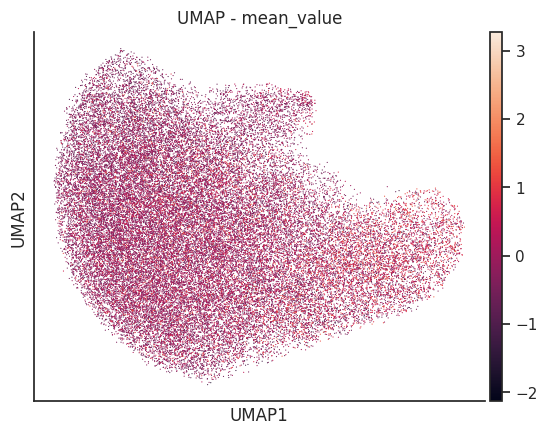

In [6]:
bmfm_adata = generate_clusters(
    bmfm_adata,
    n_components=30,
    label="mean_value",
    clustering_method="kmeans",
    n_clusters=11,
)

plot_embeddings(bmfm_adata, "mean_value")


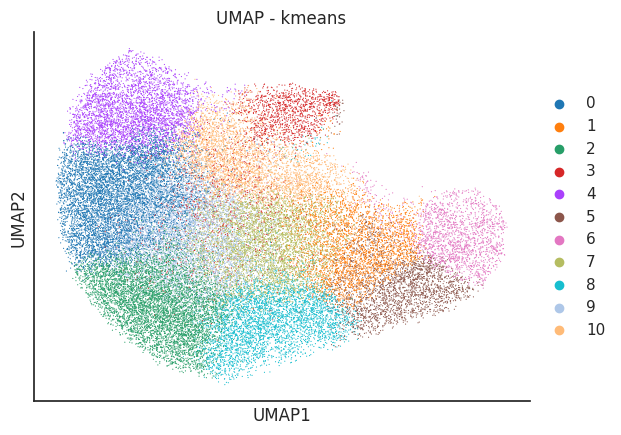

In [7]:
plot_embeddings(bmfm_adata, "kmeans")

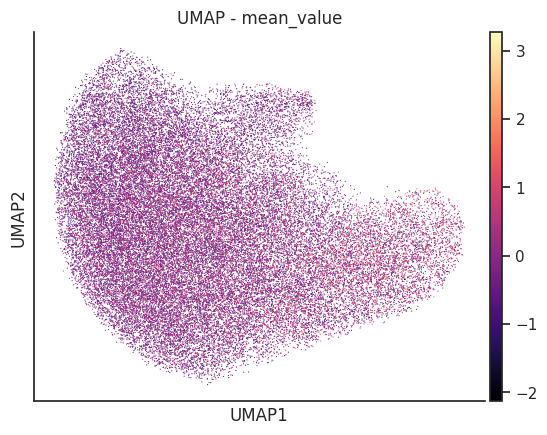

In [ ]:
labels = "mean_value"
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

title = (f"UMAP - {labels}",)
 
sc.tl.umap(bmfm_adata, n_components=2)
sc.pl.embedding(
    bmfm_adata,
    basis="umap",
    title=title,
    color=labels,
    color_map="magma",
    #palette=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"],  # your custom colors
    show=False,
)

plt.show()

In [8]:
# Try t_SNE now...
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
embeddings_2d = tsne.fit_transform(bmfm_adata.X)

In [11]:
import scipy.stats as stats

print(stats.pearsonr(embeddings_2d[:, 0],bmfm_adata.obs["mean_value"])[0])
print(stats.pearsonr(embeddings_2d[:, 1],bmfm_adata.obs["mean_value"])[0])


0.2010767003646315
-0.010849956907900055


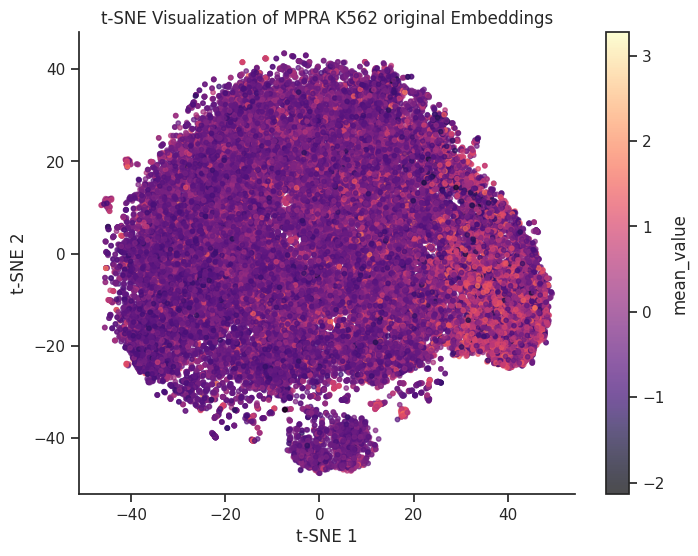

In [9]:
# 2. Plot
plt.figure(figsize=(8, 6))
colors = bmfm_adata.obs["mean_value"]
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=10, alpha=0.7, c=colors, cmap="magma")
plt.title("t-SNE Visualization of MPRA K562 original Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label="mean_value")
plt.show()

# Repeat for the snpchkpt on ref data...

In [ ]:
results = pd.read_csv("/proj/bmfm/users/sanjoy/output_dir/mpra_k562_original_test/snpckpt/embeddings.csv", index_col=0, header=None)
print(results.head(), results.shape)

        1         2         3         4         5         6         7    \
0                                                                         
0  0.095658  0.101332 -0.164776 -0.014833  0.082103 -0.046787 -0.030859   
1  0.106166  0.067405 -0.110582 -0.014930  0.080224 -0.117445  0.012430   
2  0.084682  0.103694 -0.162901  0.027216  0.083004 -0.125297  0.000993   
3  0.157180  0.064943 -0.151292 -0.011917  0.063733 -0.125251  0.011891   
4  0.000049  0.056770 -0.133662  0.031713  0.023015  0.017835 -0.084083   

        8         9         10   ...       759       760       761       762  \
0                                ...                                           
0  0.020277 -0.135259 -0.124539  ... -0.033214  0.062462 -0.094891 -0.043458   
1  0.015699 -0.141995 -0.131561  ...  0.033043  0.086819 -0.074842 -0.096419   
2  0.050982 -0.144863 -0.127916  ...  0.011107  0.099121 -0.105928 -0.065579   
3  0.018331 -0.142462 -0.099327  ...  0.064125  0.126367 -0.114784 -0.0662

In [ ]:
results.index.name = "dnaseq_id"
results.index = results.index.astype(str)
results.columns = [ f"dim_{i}" for i in range(results.shape[1])]

adata = sc.AnnData(X=results)
adata.X = adata.X.astype("float64")

print("adata:", adata)
reference_labels.index.name = "dnaseq_id"
adata.obs = reference_labels  
adata.obs.head()

        
#predictions = load_predictions(working_dir="results/pbmc3k")

bmfm_adata = adata
bmfm_adata.obs.head()

print(adata.obs.head(), adata.var.head(), adata.X.shape)

adata: AnnData object with n_obs × n_vars = 38483 × 768
                                                    sequence  mean_value  \
dnaseq_id                                                                  
0          则ATCTACATAGAAGTCGCCCTGTCCGTGATGTCACCGACAGTGCCT...       0.628   
1          TTGCTCCTTAACACAGGCTAAGGACCAGCTTCTTTGGGAGAGAACA...       1.263   
2          TCCCTGGTGGTCTAGTGGTTAGGATTCGGCGCTCTCACCGCCGCGG...      -0.924   
3          CAGGTAACTACTCTGCAAAATGAGGACACCAGGTGC高TTTTGCCCT...      -0.613   
4          TTTTGTATTTTTAGTAGAGACGGGGTTTCTCCATGTTGGTCATGCT...      -0.542   

                          name  
dnaseq_id                       
0                     peak1000  
1           peak1000_Reversed:  
2                    peak10005  
3          peak10005_Reversed:  
4                    peak10010   Empty DataFrame
Columns: []
Index: [dim_0, dim_1, dim_2, dim_3, dim_4] (38483, 768)


/proj/bmfm/users/sanjoy/miniforge3/envs/bmfm-targets/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


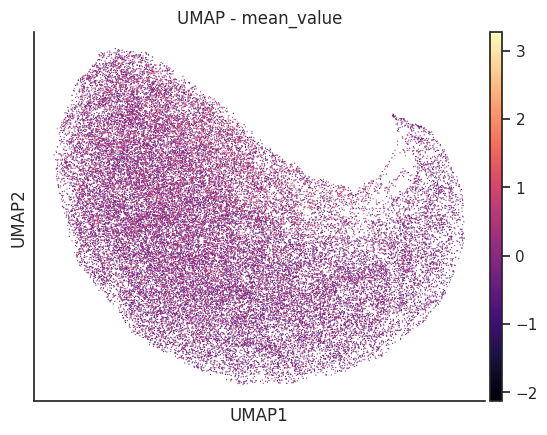

In [ ]:
bmfm_adata = generate_clusters(
    bmfm_adata,
    n_components=30,
    label="mean_value",
    clustering_method="kmeans",
    n_clusters=11,
)

labels = "mean_value"
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

title = (f"UMAP - {labels}",)
 
sc.tl.umap(bmfm_adata, n_components=2)
sc.pl.embedding(
    bmfm_adata,
    basis="umap",
    title=title,
    color=labels,
    color_map="magma",
    #palette=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"],  # your custom colors
    show=False,
)

plt.show()

In [ ]:
# Try t_SNE now...
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
embeddings_2d = tsne.fit_transform(results)

In [ ]:
import scipy.stats as stats

print(stats.pearsonr(embeddings_2d[:, 0],bmfm_adata.obs["mean_value"])[0])
print(stats.pearsonr(embeddings_2d[:, 1],bmfm_adata.obs["mean_value"])[0])


-0.05233855553307746
0.10202213247444315


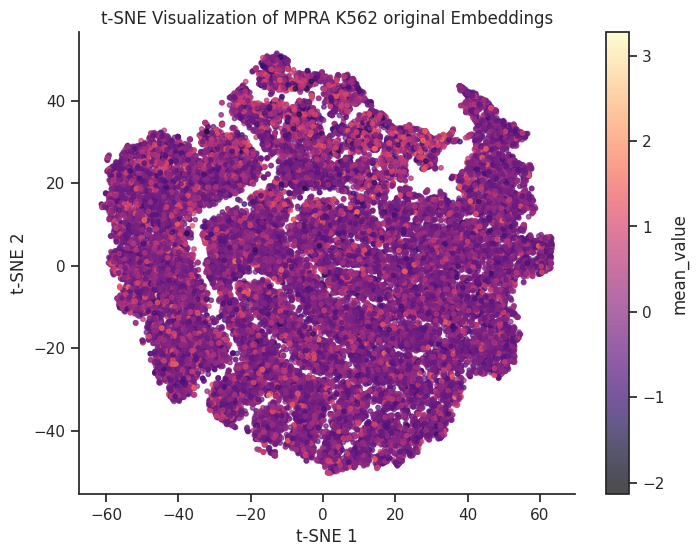

In [ ]:
# 2. Plot
plt.figure(figsize=(8, 6))
colors = bmfm_adata.obs["mean_value"]
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=10, alpha=0.7, c=colors, cmap="magma")
plt.title("t-SNE Visualization of MPRA K562 original Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label="mean_value")
plt.show()

# Repeat for the refchkpt on snpified data...



In [14]:
input_directory="/proj/bmfm/datasets/omics/genome/finetune_datasets/lenti_mpra_regression/K562_biallelic_200/"
reference_labels = pd.read_csv(input_directory + "test.csv")
reference_labels.head()

sequence  mean_value  \
0  则ATCTACATAGAAGTCGCCCTGTCCGTGATGTCACCGACAGTGCCT...       0.628   
1  TTGCTCCTTAACACAGGCTAAGGACCAGCTTCTTTGGGAGAGAACA...       1.263   
2  TCCCTGGTGGTCTAGTGGTTAGGATTCGGCGCTCTCACCGCCGCGG...      -0.924   
3  CAGGTAACTACTCTGCAAAATGAGGACACCAGGTGC高TTTTGCCCT...      -0.613   
4  TTTTGTATTTTTAGTAGAGACGGGGTTTCTCCATGTTGGTCATGCT...      -0.542   

                  name  
0             peak1000  
1   peak1000_Reversed:  
2            peak10005  
3  peak10005_Reversed:  
4            peak10010

In [12]:

results = pd.read_csv("/proj/bmfm/users/sanjoy/output_dir/mpra_k562_biallelic_test/refckpt/embeddings.csv", index_col=0, header=None)
print(results.head(), results.shape)

        1         2         3         4         5         6         7    \
0                                                                         
0 -0.096718 -0.022027 -0.046159  0.146505 -0.014279  0.097429  0.192135   
1 -0.103457 -0.013597 -0.033576  0.160030 -0.010081  0.112428  0.192500   
2 -0.088225 -0.013464 -0.033403  0.131856 -0.017585  0.069937  0.179360   
3 -0.101621  0.025326 -0.019047  0.148161 -0.021291  0.133216  0.186143   
4 -0.091829 -0.023321 -0.041937  0.154643 -0.002606  0.111848  0.180766   

        8         9         10   ...       759       760       761       762  \
0                                ...                                           
0 -0.095023  0.039707  0.032739  ...  0.007737  0.116117 -0.008410  0.101491   
1 -0.117356  0.047899  0.031527  ...  0.003188  0.096386  0.013256  0.100691   
2 -0.066324  0.064803  0.038204  ...  0.017216  0.076976 -0.013602  0.098423   
3 -0.080488  0.041968  0.024963  ...  0.028506  0.081412 -0.009771  0.1060

In [15]:
results.index.name = "dnaseq_id"
results.index = results.index.astype(str)
results.columns = [ f"dim_{i}" for i in range(results.shape[1])]

adata = sc.AnnData(X=results)
adata.X = adata.X.astype("float64")

print("adata:", adata)
reference_labels.index.name = "dnaseq_id"
adata.obs = reference_labels  
adata.obs.head()

        
#predictions = load_predictions(working_dir="results/pbmc3k")

bmfm_adata = adata
bmfm_adata.obs.head()

print(adata.obs.head(), adata.var.head(), adata.X.shape)

adata: AnnData object with n_obs × n_vars = 38483 × 768
                                                    sequence  mean_value  \
dnaseq_id                                                                  
0          则ATCTACATAGAAGTCGCCCTGTCCGTGATGTCACCGACAGTGCCT...       0.628   
1          TTGCTCCTTAACACAGGCTAAGGACCAGCTTCTTTGGGAGAGAACA...       1.263   
2          TCCCTGGTGGTCTAGTGGTTAGGATTCGGCGCTCTCACCGCCGCGG...      -0.924   
3          CAGGTAACTACTCTGCAAAATGAGGACACCAGGTGC高TTTTGCCCT...      -0.613   
4          TTTTGTATTTTTAGTAGAGACGGGGTTTCTCCATGTTGGTCATGCT...      -0.542   

                          name  
dnaseq_id                       
0                     peak1000  
1           peak1000_Reversed:  
2                    peak10005  
3          peak10005_Reversed:  
4                    peak10010   Empty DataFrame
Columns: []
Index: [dim_0, dim_1, dim_2, dim_3, dim_4] (38483, 768)


### Plot embeddings

To view the embeddings and paint the cell-type annotations on the UMAP the embeddings will be extracted from the results. Then you can run unsupervised clustering and UMAP projection on the embeddings from inference step.

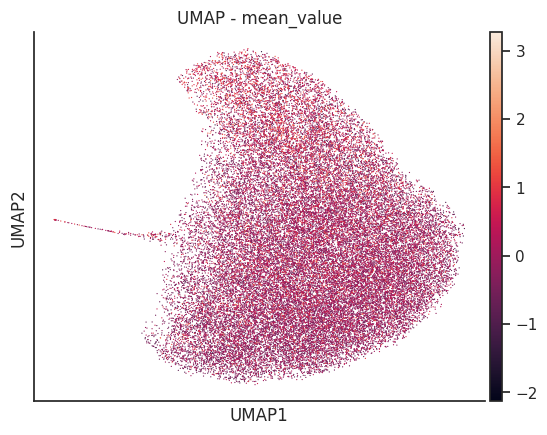

In [ ]:
bmfm_adata = generate_clusters(
    bmfm_adata,
    n_components=30,
    label="mean_value",
    clustering_method="kmeans",
    n_clusters=11,
)

#plot_embeddings(bmfm_adata, "mean_value")


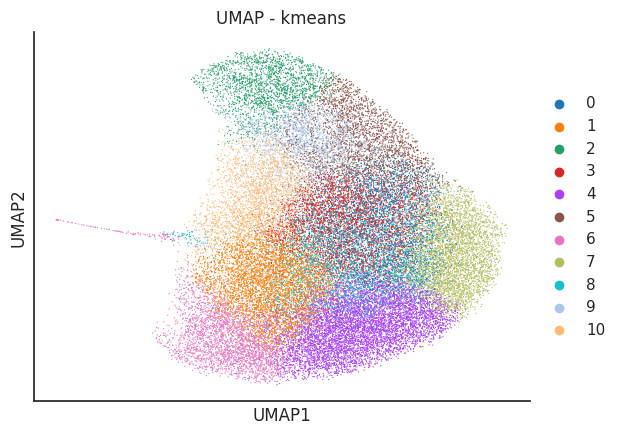

In [19]:
plot_embeddings(bmfm_adata, "kmeans")

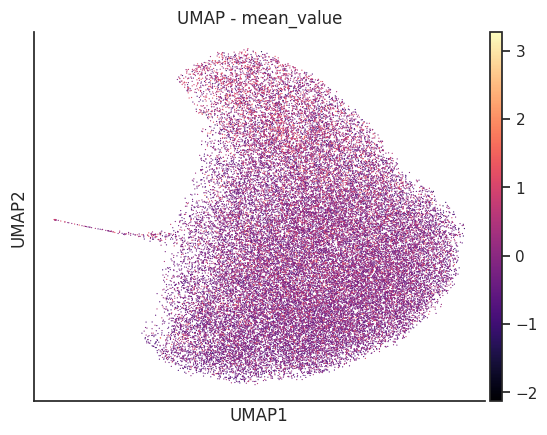

In [20]:
labels = "mean_value"
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

title = (f"UMAP - {labels}",)
 
sc.tl.umap(bmfm_adata, n_components=2)
sc.pl.embedding(
    bmfm_adata,
    basis="umap",
    title=title,
    color=labels,
    color_map="magma",
    #palette=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"],  # your custom colors
    show=False,
)

plt.show()

In [21]:
# Try t_SNE now...
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
embeddings_2d = tsne.fit_transform(bmfm_adata.X)

In [22]:
import scipy.stats as stats

print(stats.pearsonr(embeddings_2d[:, 0],bmfm_adata.obs["mean_value"])[0])
print(stats.pearsonr(embeddings_2d[:, 1],bmfm_adata.obs["mean_value"])[0])


0.17694285445113142
-0.023458936346617817


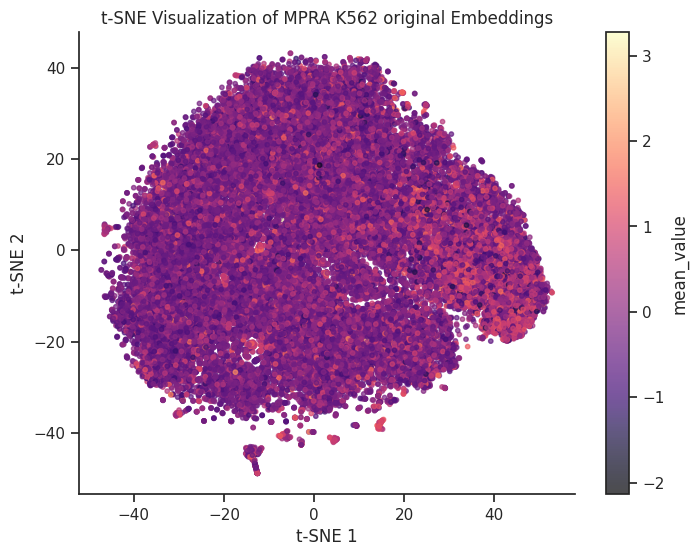

In [23]:
# 2. Plot
plt.figure(figsize=(8, 6))
colors = bmfm_adata.obs["mean_value"]
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=10, alpha=0.7, c=colors, cmap="magma")
plt.title("t-SNE Visualization of MPRA K562 original Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label="mean_value")
plt.show()

# Repeat for the snpchkpt on snpified data...

In [32]:
results = pd.read_csv("/proj/bmfm/users/sanjoy/output_dir/mpra_k562_biallelic_test/snpckpt/embeddings.csv", index_col=0, header=None)
print(results.head(), results.shape)

        1         2         3         4         5         6         7    \
0                                                                         
0  0.095658  0.101332 -0.164776 -0.014833  0.082103 -0.046787 -0.030859   
1  0.106166  0.067405 -0.110582 -0.014930  0.080224 -0.117445  0.012430   
2  0.084682  0.103694 -0.162901  0.027216  0.083004 -0.125297  0.000993   
3  0.157180  0.064943 -0.151292 -0.011917  0.063733 -0.125251  0.011891   
4  0.000049  0.056770 -0.133662  0.031713  0.023015  0.017835 -0.084083   

        8         9         10   ...       759       760       761       762  \
0                                ...                                           
0  0.020277 -0.135259 -0.124539  ... -0.033214  0.062462 -0.094891 -0.043458   
1  0.015699 -0.141995 -0.131561  ...  0.033043  0.086819 -0.074842 -0.096419   
2  0.050982 -0.144863 -0.127916  ...  0.011107  0.099121 -0.105928 -0.065579   
3  0.018331 -0.142462 -0.099327  ...  0.064125  0.126367 -0.114784 -0.0662

In [25]:
results.index.name = "dnaseq_id"
results.index = results.index.astype(str)
results.columns = [ f"dim_{i}" for i in range(results.shape[1])]

adata = sc.AnnData(X=results)
adata.X = adata.X.astype("float64")

print("adata:", adata)
reference_labels.index.name = "dnaseq_id"
adata.obs = reference_labels  
adata.obs.head()

        
#predictions = load_predictions(working_dir="results/pbmc3k")

bmfm_adata = adata
bmfm_adata.obs.head()

print(adata.obs.head(), adata.var.head(), adata.X.shape)

adata: AnnData object with n_obs × n_vars = 38483 × 768
                                                    sequence  mean_value  \
dnaseq_id                                                                  
0          则ATCTACATAGAAGTCGCCCTGTCCGTGATGTCACCGACAGTGCCT...       0.628   
1          TTGCTCCTTAACACAGGCTAAGGACCAGCTTCTTTGGGAGAGAACA...       1.263   
2          TCCCTGGTGGTCTAGTGGTTAGGATTCGGCGCTCTCACCGCCGCGG...      -0.924   
3          CAGGTAACTACTCTGCAAAATGAGGACACCAGGTGC高TTTTGCCCT...      -0.613   
4          TTTTGTATTTTTAGTAGAGACGGGGTTTCTCCATGTTGGTCATGCT...      -0.542   

                          name  
dnaseq_id                       
0                     peak1000  
1           peak1000_Reversed:  
2                    peak10005  
3          peak10005_Reversed:  
4                    peak10010   Empty DataFrame
Columns: []
Index: [dim_0, dim_1, dim_2, dim_3, dim_4] (38483, 768)


/proj/bmfm/users/sanjoy/miniforge3/envs/bmfm-targets/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


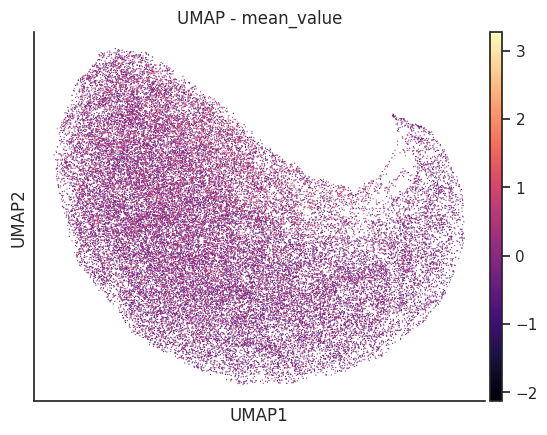

In [26]:
bmfm_adata = generate_clusters(
    bmfm_adata,
    n_components=30,
    label="mean_value",
    clustering_method="kmeans",
    n_clusters=11,
)

labels = "mean_value"
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

title = (f"UMAP - {labels}",)
 
sc.tl.umap(bmfm_adata, n_components=2)
sc.pl.embedding(
    bmfm_adata,
    basis="umap",
    title=title,
    color=labels,
    color_map="magma",
    #palette=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"],  # your custom colors
    show=False,
)

plt.show()

In [30]:
# Try t_SNE now...
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
embeddings_2d = tsne.fit_transform(results)

In [31]:
import scipy.stats as stats

print(stats.pearsonr(embeddings_2d[:, 0],bmfm_adata.obs["mean_value"])[0])
print(stats.pearsonr(embeddings_2d[:, 1],bmfm_adata.obs["mean_value"])[0])


-0.05233855553307746
0.10202213247444315


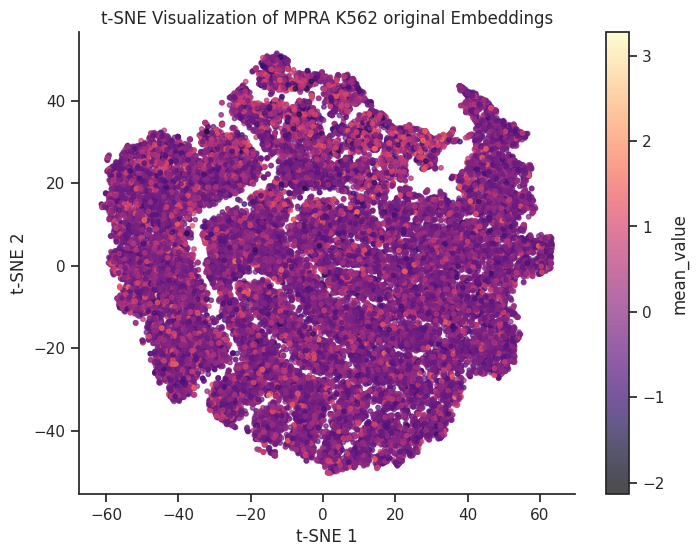

In [33]:
# 2. Plot
plt.figure(figsize=(8, 6))
colors = bmfm_adata.obs["mean_value"]
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=10, alpha=0.7, c=colors, cmap="magma")
plt.title("t-SNE Visualization of MPRA K562 original Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label="mean_value")
plt.show()

# Now repeat it for the finetuned model with ref chkpt...


In [ ]:
# bsub -M 50G -n 8 -gpu "num=1:mode=exclusive_process" -o mpra_k562_test_ref_fn.out -e mpra_k562_test_ref_fn.err -W 24:00 bash -c 'bmfm-targets-run -cn dna_predict \
    working_dir=/proj/bmfm/users/sanjoy/output_dir/mpra_k562_test/finetuned \
    data_module.collation_strategy=language_modeling \ 
    checkpoint=/proj/bmfm/users/sanjoy/benchmarking/modernbert_wo_lora_ref_v3.3lr0.0001_pe128_wd0.01_batch_dump/mpra_K562_original/epoch=23-step=52835-val_loss=0.13.ckpt \
    accelerator=cpu \
    input_directory=/proj/bmfm/datasets/omics/genome/finetune_datasets/lenti_mpra_regression/K562_original/ \
    label_column_name=mean_value dataset_name=mpra_k562_original input_filename=test.csv'

The `bmfm.rna.bert.110m.wced.multitask.v1` model is trained on the most coarse cell labels as defined by the data on CellXGene. 

In some cases you may want to try and generalize the cell labels. To do this you can use the helper function `get_general_cell_type` and set the level to `sub_class` to create general cell annotations.

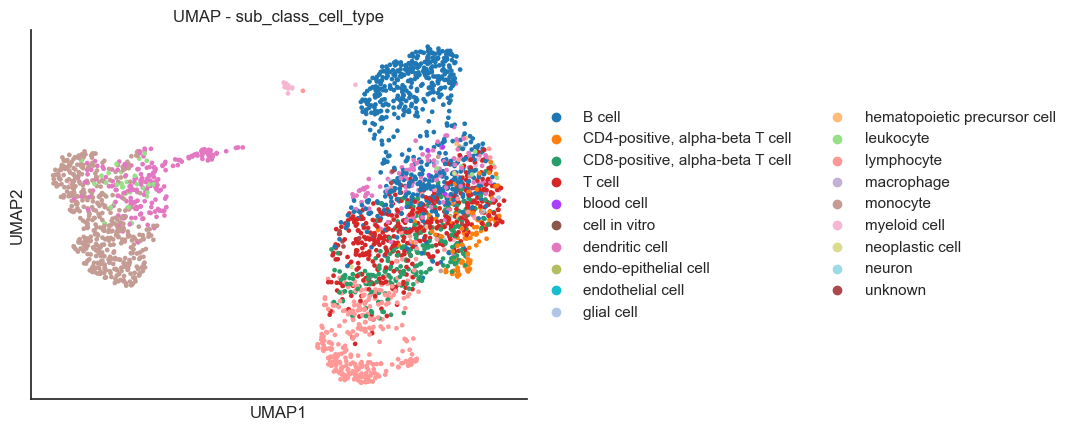

In [5]:
bmfm_adata = get_general_cell_type(bmfm_adata, level="sub_class")
plot_embeddings(bmfm_adata, "sub_class_cell_type")

The original labelling of the PMBC3K dataset can then also be projected onto the UMAP here as the ground truth labels to observe the how similar the are to the predicted cell type labels.